## 케라스 자동차 연비 예측 모델

- Source : https://www.tensorflow.org/tutorials/keras/regression

### modules import

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import get_file, plot_model

In [2]:
sns.set(style = 'white')
plt.style.use('seaborn-white')

### 데이터 로드

In [3]:
dataset_path = get_file('auto-mpg.data', 
                        'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')
dataset_path

'C:\\Users\\LEE\\.keras\\datasets\\auto-mpg.data'

In [4]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

### 데이터 확인

In [5]:
raw_dataset = pd.read_csv(dataset_path, names = column_names,
                         na_values= '?', comment = '\t',
                         sep = " ", skipinitialspace = True)

dataset = raw_dataset.copy()
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


### 데이터 전처리

- 해당 데이터는 일부 데이터가 누락되어 있음

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

- 누락된 행 삭제

In [7]:
dataset = dataset.dropna()

- "Origin" 범주형 데이터
  - 원-핫 인코딩(one-hot encoding) 진행

In [8]:
dataset['Origin'].unique()

array([1, 3, 2], dtype=int64)

In [9]:
origin = dataset.pop('Origin')

In [10]:
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset

<ipython-input-10-e9910cf9e049>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['USA'] = (origin == 1) * 1.0
<ipython-input-10-e9910cf9e049>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Europe'] = (origin == 2) * 1.0
<ipython-input-10-e9910cf9e049>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0


#### 검증 데이터셋 생성

In [11]:
train_dataset = dataset.sample(frac = 0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

#### 데이터 조사

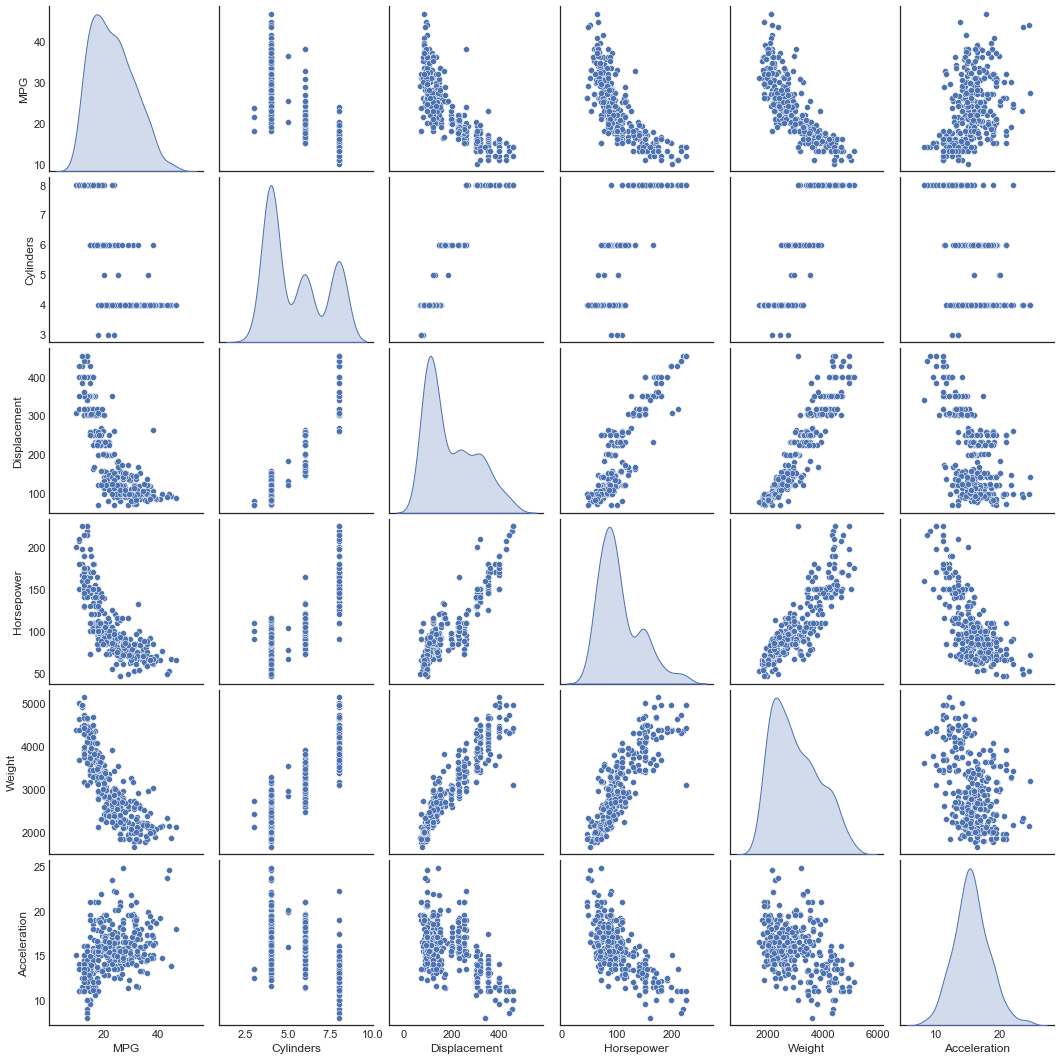

In [12]:
sns.pairplot(train_dataset[["MPG", "Cylinders", 'Displacement', 'Horsepower', 'Weight', 'Acceleration']],
            diag_kind = 'kde')

In [13]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


#### 데이터의 특성과 레이블 분리

In [14]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

#### 데이터 정규화

In [15]:
def normalization(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = normalization(train_dataset)
normed_test_data = normalization(test_dataset)

### 모델 구성

In [16]:
def build_model():
    input = Input(shape = (len(train_dataset.keys())), name = 'input')
    # 데이터셋이 적기 때문에 모델의 깊이를 너무 깊게가져가면 안됨 >> '64'로 지정
    hidden1 = Dense(64, activation = 'relu', name = 'dense1')(input)
    hidden2 = Dense(64, activation = 'relu', name = 'dense2')(hidden1)
    output = Dense(1, name = 'output')(hidden2)
    
    model = Model(input, output)
    
    model.compile(loss = 'mse',
                 optimizer = RMSprop(learning_rate = 0.001),
                 metrics = ['mae', 'mse'])
    
    return model

In [17]:
model = build_model()

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 9)]               0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                640       
_________________________________________________________________
dense2 (Dense)               (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


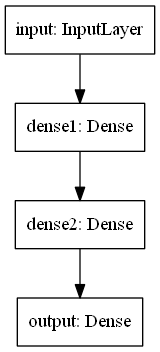

In [19]:
plot_model(model)

### 샘플 데이터 확인

In [20]:
sample_batch = normed_train_data[:10]
sample_result = model.predict(sample_batch)
sample_batch

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852
257,0.307270,0.351586,-0.390312,0.260397,0.588250,0.571849,0.774676,-0.465148,-0.495225
310,-0.869348,-1.019044,-1.177792,-1.211344,1.161885,1.115971,-1.286751,-0.465148,2.012852
328,-0.869348,-0.472709,-0.994047,0.307796,2.237451,1.115971,-1.286751,2.143005,-0.495225
125,0.307270,0.025702,-0.259066,0.132419,0.337285,-0.516397,0.774676,-0.465148,-0.495225
108,-0.869348,-0.942365,-0.442811,-0.842816,1.233589,-0.788458,-1.286751,-0.465148,2.012852


### 모델 학습

In [21]:
epochs = 1000

history = model.fit(normed_train_data, train_labels,
                   epochs = epochs, validation_split = 0.2)

Epoch 1/1000
8/8 [==============================] - 1s 23ms/step - loss: 538.1573 - mae: 21.9829 - mse: 538.1573 - val_loss: 517.4932 - val_mae: 21.5337 - val_mse: 517.4932
Epoch 2/1000
8/8 [==============================] - 0s 7ms/step - loss: 474.6225 - mae: 20.5755 - mse: 474.6225 - val_loss: 449.9203 - val_mae: 20.0192 - val_mse: 449.9203
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 410.2904 - mae: 19.0758 - mse: 410.2904 - val_loss: 376.7026 - val_mae: 18.2503 - val_mse: 376.7026
Epoch 4/1000
8/8 [==============================] - 0s 8ms/step - loss: 341.9886 - mae: 17.3558 - mse: 341.9886 - val_loss: 302.9192 - val_mae: 16.2673 - val_mse: 302.9192
Epoch 5/1000
8/8 [==============================] - 0s 8ms/step - loss: 273.3594 - mae: 15.3778 - mse: 273.3594 - val_loss: 230.0520 - val_mae: 14.0385 - val_mse: 230.0520
Epoch 6/1000
8/8 [==============================] - 0s 8ms/step - loss: 208.1331 - mae: 13.2674 - mse: 208.1331 - val_loss: 164.9651 - val_

8/8 [==============================] - 0s 8ms/step - loss: 6.1581 - mae: 1.7756 - mse: 6.1581 - val_loss: 7.7653 - val_mae: 2.2164 - val_mse: 7.7653
Epoch 101/1000
8/8 [==============================] - 0s 6ms/step - loss: 6.0756 - mae: 1.6999 - mse: 6.0756 - val_loss: 7.4495 - val_mae: 2.1171 - val_mse: 7.4495
Epoch 102/1000
8/8 [==============================] - 0s 8ms/step - loss: 5.9590 - mae: 1.7046 - mse: 5.9590 - val_loss: 7.6317 - val_mae: 2.1081 - val_mse: 7.6317
Epoch 103/1000
8/8 [==============================] - 0s 8ms/step - loss: 5.9635 - mae: 1.7048 - mse: 5.9635 - val_loss: 7.9019 - val_mae: 2.0634 - val_mse: 7.9019
Epoch 104/1000
8/8 [==============================] - 0s 8ms/step - loss: 5.9654 - mae: 1.7153 - mse: 5.9654 - val_loss: 8.2456 - val_mae: 2.2859 - val_mse: 8.2456
Epoch 105/1000
8/8 [==============================] - 0s 7ms/step - loss: 6.0350 - mae: 1.7325 - mse: 6.0350 - val_loss: 7.6391 - val_mae: 2.1508 - val_mse: 7.6391
Epoch 106/1000
8/8 [===========

8/8 [==============================] - 0s 8ms/step - loss: 5.7471 - mae: 1.6712 - mse: 5.7471 - val_loss: 7.6441 - val_mae: 2.1710 - val_mse: 7.6441
Epoch 151/1000
8/8 [==============================] - 0s 8ms/step - loss: 5.6286 - mae: 1.6352 - mse: 5.6286 - val_loss: 7.5144 - val_mae: 2.1360 - val_mse: 7.5144
Epoch 152/1000
8/8 [==============================] - 0s 7ms/step - loss: 5.5954 - mae: 1.6004 - mse: 5.5954 - val_loss: 7.6113 - val_mae: 2.0538 - val_mse: 7.6113
Epoch 153/1000
8/8 [==============================] - 0s 6ms/step - loss: 5.5615 - mae: 1.6285 - mse: 5.5615 - val_loss: 7.5089 - val_mae: 2.1387 - val_mse: 7.5089
Epoch 154/1000
8/8 [==============================] - 0s 6ms/step - loss: 5.5658 - mae: 1.6484 - mse: 5.5658 - val_loss: 7.6855 - val_mae: 2.2032 - val_mse: 7.6855
Epoch 155/1000
8/8 [==============================] - 0s 6ms/step - loss: 5.6644 - mae: 1.6249 - mse: 5.6644 - val_loss: 7.3512 - val_mae: 2.0712 - val_mse: 7.3512
Epoch 156/1000
8/8 [===========

8/8 [==============================] - 0s 8ms/step - loss: 5.2196 - mae: 1.5863 - mse: 5.2196 - val_loss: 7.4727 - val_mae: 2.1060 - val_mse: 7.4727
Epoch 201/1000
8/8 [==============================] - 0s 7ms/step - loss: 5.1809 - mae: 1.5508 - mse: 5.1809 - val_loss: 7.2334 - val_mae: 2.0504 - val_mse: 7.2334
Epoch 202/1000
8/8 [==============================] - 0s 7ms/step - loss: 5.2936 - mae: 1.5880 - mse: 5.2936 - val_loss: 8.2110 - val_mae: 2.2409 - val_mse: 8.2110
Epoch 203/1000
8/8 [==============================] - 0s 7ms/step - loss: 5.2120 - mae: 1.5521 - mse: 5.2120 - val_loss: 7.2915 - val_mae: 2.0485 - val_mse: 7.2915
Epoch 204/1000
8/8 [==============================] - 0s 8ms/step - loss: 5.2262 - mae: 1.5790 - mse: 5.2262 - val_loss: 7.7214 - val_mae: 2.1289 - val_mse: 7.7214
Epoch 205/1000
8/8 [==============================] - 0s 7ms/step - loss: 5.4186 - mae: 1.5731 - mse: 5.4186 - val_loss: 7.4333 - val_mae: 2.0275 - val_mse: 7.4333
Epoch 206/1000
8/8 [===========

8/8 [==============================] - 0s 9ms/step - loss: 4.9929 - mae: 1.5352 - mse: 4.9929 - val_loss: 7.6011 - val_mae: 2.1502 - val_mse: 7.6011
Epoch 251/1000
8/8 [==============================] - 0s 8ms/step - loss: 5.1186 - mae: 1.5490 - mse: 5.1186 - val_loss: 7.5641 - val_mae: 2.0638 - val_mse: 7.5641
Epoch 252/1000
8/8 [==============================] - 0s 8ms/step - loss: 5.0775 - mae: 1.5501 - mse: 5.0775 - val_loss: 7.4994 - val_mae: 2.1080 - val_mse: 7.4994
Epoch 253/1000
8/8 [==============================] - 0s 7ms/step - loss: 4.9356 - mae: 1.5337 - mse: 4.9356 - val_loss: 7.3092 - val_mae: 2.0519 - val_mse: 7.3092
Epoch 254/1000
8/8 [==============================] - 0s 7ms/step - loss: 4.9488 - mae: 1.4977 - mse: 4.9488 - val_loss: 7.4105 - val_mae: 2.0416 - val_mse: 7.4105
Epoch 255/1000
8/8 [==============================] - 0s 6ms/step - loss: 4.9314 - mae: 1.5075 - mse: 4.9314 - val_loss: 7.4427 - val_mae: 2.0414 - val_mse: 7.4427
Epoch 256/1000
8/8 [===========

8/8 [==============================] - 0s 6ms/step - loss: 4.6743 - mae: 1.4537 - mse: 4.6743 - val_loss: 8.1035 - val_mae: 2.0820 - val_mse: 8.1035
Epoch 301/1000
8/8 [==============================] - 0s 6ms/step - loss: 5.0769 - mae: 1.4806 - mse: 5.0769 - val_loss: 7.9198 - val_mae: 2.0564 - val_mse: 7.9198
Epoch 302/1000
8/8 [==============================] - 0s 8ms/step - loss: 4.7162 - mae: 1.4722 - mse: 4.7162 - val_loss: 7.6964 - val_mae: 2.1109 - val_mse: 7.6964
Epoch 303/1000
8/8 [==============================] - 0s 7ms/step - loss: 4.9220 - mae: 1.5081 - mse: 4.9220 - val_loss: 7.7727 - val_mae: 2.0878 - val_mse: 7.7727
Epoch 304/1000
8/8 [==============================] - 0s 7ms/step - loss: 4.7981 - mae: 1.4692 - mse: 4.7981 - val_loss: 7.9154 - val_mae: 2.1532 - val_mse: 7.9154
Epoch 305/1000
8/8 [==============================] - 0s 7ms/step - loss: 4.7912 - mae: 1.4551 - mse: 4.7912 - val_loss: 7.8447 - val_mae: 2.1582 - val_mse: 7.8447
Epoch 306/1000
8/8 [===========

8/8 [==============================] - 0s 8ms/step - loss: 4.7296 - mae: 1.4411 - mse: 4.7296 - val_loss: 7.6948 - val_mae: 2.1075 - val_mse: 7.6948
Epoch 351/1000
8/8 [==============================] - 0s 7ms/step - loss: 4.3691 - mae: 1.3973 - mse: 4.3691 - val_loss: 7.7533 - val_mae: 2.0517 - val_mse: 7.7533
Epoch 352/1000
8/8 [==============================] - 0s 7ms/step - loss: 4.5661 - mae: 1.4087 - mse: 4.5661 - val_loss: 7.5602 - val_mae: 2.0423 - val_mse: 7.5602
Epoch 353/1000
8/8 [==============================] - 0s 7ms/step - loss: 4.5115 - mae: 1.4216 - mse: 4.5115 - val_loss: 7.9244 - val_mae: 2.1249 - val_mse: 7.9244
Epoch 354/1000
8/8 [==============================] - 0s 7ms/step - loss: 4.8046 - mae: 1.4758 - mse: 4.8046 - val_loss: 7.6754 - val_mae: 2.0968 - val_mse: 7.6754
Epoch 355/1000
8/8 [==============================] - 0s 7ms/step - loss: 4.3955 - mae: 1.3898 - mse: 4.3955 - val_loss: 7.8759 - val_mae: 2.1422 - val_mse: 7.8759
Epoch 356/1000
8/8 [===========

8/8 [==============================] - 0s 8ms/step - loss: 4.3491 - mae: 1.3823 - mse: 4.3491 - val_loss: 7.7283 - val_mae: 2.1232 - val_mse: 7.7283
Epoch 401/1000
8/8 [==============================] - 0s 7ms/step - loss: 4.2160 - mae: 1.3652 - mse: 4.2160 - val_loss: 7.6769 - val_mae: 2.1015 - val_mse: 7.6769
Epoch 402/1000
8/8 [==============================] - 0s 9ms/step - loss: 4.2728 - mae: 1.3677 - mse: 4.2728 - val_loss: 7.9634 - val_mae: 2.1715 - val_mse: 7.9634
Epoch 403/1000
8/8 [==============================] - 0s 8ms/step - loss: 4.4462 - mae: 1.3950 - mse: 4.4462 - val_loss: 7.8988 - val_mae: 2.1796 - val_mse: 7.8988
Epoch 404/1000
8/8 [==============================] - 0s 8ms/step - loss: 4.4893 - mae: 1.4008 - mse: 4.4893 - val_loss: 7.7072 - val_mae: 2.0847 - val_mse: 7.7072
Epoch 405/1000
8/8 [==============================] - 0s 8ms/step - loss: 4.1851 - mae: 1.3609 - mse: 4.1851 - val_loss: 7.7280 - val_mae: 2.1416 - val_mse: 7.7280
Epoch 406/1000
8/8 [===========

8/8 [==============================] - 0s 7ms/step - loss: 4.2907 - mae: 1.3924 - mse: 4.2907 - val_loss: 7.5112 - val_mae: 2.0906 - val_mse: 7.5112
Epoch 451/1000
8/8 [==============================] - 0s 8ms/step - loss: 4.3624 - mae: 1.3451 - mse: 4.3624 - val_loss: 7.7269 - val_mae: 2.1286 - val_mse: 7.7269
Epoch 452/1000
8/8 [==============================] - 0s 7ms/step - loss: 4.0546 - mae: 1.3224 - mse: 4.0546 - val_loss: 8.0621 - val_mae: 2.1838 - val_mse: 8.0621
Epoch 453/1000
8/8 [==============================] - 0s 7ms/step - loss: 4.1834 - mae: 1.3497 - mse: 4.1834 - val_loss: 7.8504 - val_mae: 2.1589 - val_mse: 7.8504
Epoch 454/1000
8/8 [==============================] - 0s 7ms/step - loss: 4.2825 - mae: 1.3625 - mse: 4.2825 - val_loss: 7.5061 - val_mae: 2.0775 - val_mse: 7.5061
Epoch 455/1000
8/8 [==============================] - 0s 8ms/step - loss: 4.0608 - mae: 1.3232 - mse: 4.0608 - val_loss: 7.8768 - val_mae: 2.1351 - val_mse: 7.8768
Epoch 456/1000
8/8 [===========

8/8 [==============================] - 0s 7ms/step - loss: 3.9901 - mae: 1.2988 - mse: 3.9901 - val_loss: 7.5156 - val_mae: 2.0935 - val_mse: 7.5156
Epoch 501/1000
8/8 [==============================] - 0s 7ms/step - loss: 4.0475 - mae: 1.3296 - mse: 4.0475 - val_loss: 7.9433 - val_mae: 2.1745 - val_mse: 7.9433
Epoch 502/1000
8/8 [==============================] - 0s 7ms/step - loss: 4.0778 - mae: 1.3172 - mse: 4.0778 - val_loss: 7.6111 - val_mae: 2.1301 - val_mse: 7.6111
Epoch 503/1000
8/8 [==============================] - 0s 7ms/step - loss: 4.0367 - mae: 1.2957 - mse: 4.0367 - val_loss: 8.4857 - val_mae: 2.2272 - val_mse: 8.4857
Epoch 504/1000
8/8 [==============================] - 0s 8ms/step - loss: 3.9792 - mae: 1.3070 - mse: 3.9792 - val_loss: 8.2198 - val_mae: 2.1864 - val_mse: 8.2198
Epoch 505/1000
8/8 [==============================] - 0s 7ms/step - loss: 4.0816 - mae: 1.3084 - mse: 4.0816 - val_loss: 8.0864 - val_mae: 2.1810 - val_mse: 8.0864
Epoch 506/1000
8/8 [===========

8/8 [==============================] - 0s 7ms/step - loss: 3.8293 - mae: 1.2968 - mse: 3.8293 - val_loss: 7.6281 - val_mae: 2.1045 - val_mse: 7.6281
Epoch 551/1000
8/8 [==============================] - 0s 7ms/step - loss: 3.7020 - mae: 1.2463 - mse: 3.7020 - val_loss: 7.6958 - val_mae: 2.1235 - val_mse: 7.6958
Epoch 552/1000
8/8 [==============================] - 0s 8ms/step - loss: 4.0671 - mae: 1.3273 - mse: 4.0671 - val_loss: 7.9071 - val_mae: 2.1532 - val_mse: 7.9071
Epoch 553/1000
8/8 [==============================] - 0s 7ms/step - loss: 3.7368 - mae: 1.2628 - mse: 3.7368 - val_loss: 8.4158 - val_mae: 2.2041 - val_mse: 8.4158
Epoch 554/1000
8/8 [==============================] - 0s 7ms/step - loss: 3.8612 - mae: 1.2924 - mse: 3.8612 - val_loss: 7.8645 - val_mae: 2.1541 - val_mse: 7.8645
Epoch 555/1000
8/8 [==============================] - 0s 8ms/step - loss: 3.8809 - mae: 1.2849 - mse: 3.8809 - val_loss: 8.0483 - val_mae: 2.1842 - val_mse: 8.0483
Epoch 556/1000
8/8 [===========

8/8 [==============================] - 0s 7ms/step - loss: 3.7128 - mae: 1.2558 - mse: 3.7128 - val_loss: 8.5519 - val_mae: 2.2226 - val_mse: 8.5519
Epoch 601/1000
8/8 [==============================] - 0s 8ms/step - loss: 3.8369 - mae: 1.2831 - mse: 3.8369 - val_loss: 8.3048 - val_mae: 2.1925 - val_mse: 8.3048
Epoch 602/1000
8/8 [==============================] - 0s 7ms/step - loss: 3.8123 - mae: 1.2498 - mse: 3.8123 - val_loss: 8.3148 - val_mae: 2.2178 - val_mse: 8.3148
Epoch 603/1000
8/8 [==============================] - 0s 7ms/step - loss: 3.6662 - mae: 1.2324 - mse: 3.6662 - val_loss: 7.7156 - val_mae: 2.1444 - val_mse: 7.7156
Epoch 604/1000
8/8 [==============================] - 0s 7ms/step - loss: 3.7193 - mae: 1.2801 - mse: 3.7193 - val_loss: 7.8250 - val_mae: 2.1587 - val_mse: 7.8250
Epoch 605/1000
8/8 [==============================] - 0s 8ms/step - loss: 3.6386 - mae: 1.2408 - mse: 3.6386 - val_loss: 7.8814 - val_mae: 2.1579 - val_mse: 7.8814
Epoch 606/1000
8/8 [===========

8/8 [==============================] - 0s 8ms/step - loss: 3.4356 - mae: 1.2214 - mse: 3.4356 - val_loss: 8.4301 - val_mae: 2.2346 - val_mse: 8.4301
Epoch 651/1000
8/8 [==============================] - 0s 7ms/step - loss: 3.5156 - mae: 1.1889 - mse: 3.5156 - val_loss: 7.9119 - val_mae: 2.1654 - val_mse: 7.9119
Epoch 652/1000
8/8 [==============================] - 0s 7ms/step - loss: 3.6373 - mae: 1.2853 - mse: 3.6373 - val_loss: 8.1654 - val_mae: 2.1754 - val_mse: 8.1654
Epoch 653/1000
8/8 [==============================] - 0s 6ms/step - loss: 3.5139 - mae: 1.1974 - mse: 3.5139 - val_loss: 7.8413 - val_mae: 2.1846 - val_mse: 7.8413
Epoch 654/1000
8/8 [==============================] - 0s 7ms/step - loss: 3.3419 - mae: 1.1970 - mse: 3.3419 - val_loss: 7.9805 - val_mae: 2.1704 - val_mse: 7.9805
Epoch 655/1000
8/8 [==============================] - 0s 12ms/step - loss: 3.4892 - mae: 1.2230 - mse: 3.4892 - val_loss: 8.0941 - val_mae: 2.1705 - val_mse: 8.0941
Epoch 656/1000
8/8 [==========

8/8 [==============================] - 0s 7ms/step - loss: 3.4805 - mae: 1.2426 - mse: 3.4805 - val_loss: 7.8775 - val_mae: 2.1892 - val_mse: 7.8775
Epoch 701/1000
8/8 [==============================] - 0s 6ms/step - loss: 3.3104 - mae: 1.2082 - mse: 3.3104 - val_loss: 9.0571 - val_mae: 2.3145 - val_mse: 9.0571
Epoch 702/1000
8/8 [==============================] - 0s 7ms/step - loss: 3.4979 - mae: 1.2238 - mse: 3.4979 - val_loss: 8.4189 - val_mae: 2.2417 - val_mse: 8.4189
Epoch 703/1000
8/8 [==============================] - 0s 7ms/step - loss: 3.1723 - mae: 1.1848 - mse: 3.1723 - val_loss: 9.2534 - val_mae: 2.3494 - val_mse: 9.2534
Epoch 704/1000
8/8 [==============================] - 0s 7ms/step - loss: 3.3110 - mae: 1.1984 - mse: 3.3110 - val_loss: 7.6997 - val_mae: 2.1530 - val_mse: 7.6997
Epoch 705/1000
8/8 [==============================] - 0s 7ms/step - loss: 3.3507 - mae: 1.2300 - mse: 3.3507 - val_loss: 7.7969 - val_mae: 2.1696 - val_mse: 7.7969
Epoch 706/1000
8/8 [===========

8/8 [==============================] - 0s 8ms/step - loss: 3.0951 - mae: 1.1654 - mse: 3.0951 - val_loss: 8.4670 - val_mae: 2.2414 - val_mse: 8.4670
Epoch 751/1000
8/8 [==============================] - 0s 8ms/step - loss: 3.3604 - mae: 1.2107 - mse: 3.3604 - val_loss: 7.8200 - val_mae: 2.1784 - val_mse: 7.8200
Epoch 752/1000
8/8 [==============================] - 0s 8ms/step - loss: 3.1683 - mae: 1.1416 - mse: 3.1683 - val_loss: 8.0108 - val_mae: 2.2171 - val_mse: 8.0108
Epoch 753/1000
8/8 [==============================] - 0s 7ms/step - loss: 3.1320 - mae: 1.1459 - mse: 3.1320 - val_loss: 8.4282 - val_mae: 2.2599 - val_mse: 8.4282
Epoch 754/1000
8/8 [==============================] - 0s 7ms/step - loss: 3.2049 - mae: 1.1474 - mse: 3.2049 - val_loss: 8.0066 - val_mae: 2.1825 - val_mse: 8.0066
Epoch 755/1000
8/8 [==============================] - 0s 8ms/step - loss: 3.1618 - mae: 1.1581 - mse: 3.1618 - val_loss: 8.1432 - val_mae: 2.2249 - val_mse: 8.1432
Epoch 756/1000
8/8 [===========

8/8 [==============================] - 0s 8ms/step - loss: 3.1965 - mae: 1.1490 - mse: 3.1965 - val_loss: 8.1733 - val_mae: 2.2072 - val_mse: 8.1733
Epoch 801/1000
8/8 [==============================] - 0s 7ms/step - loss: 3.1102 - mae: 1.1424 - mse: 3.1102 - val_loss: 7.7198 - val_mae: 2.1432 - val_mse: 7.7198
Epoch 802/1000
8/8 [==============================] - 0s 6ms/step - loss: 3.1091 - mae: 1.1255 - mse: 3.1091 - val_loss: 8.5917 - val_mae: 2.2536 - val_mse: 8.5917
Epoch 803/1000
8/8 [==============================] - 0s 7ms/step - loss: 3.1013 - mae: 1.1447 - mse: 3.1013 - val_loss: 7.8338 - val_mae: 2.1757 - val_mse: 7.8338
Epoch 804/1000
8/8 [==============================] - 0s 8ms/step - loss: 3.0253 - mae: 1.1186 - mse: 3.0253 - val_loss: 8.0505 - val_mae: 2.1916 - val_mse: 8.0505
Epoch 805/1000
8/8 [==============================] - 0s 7ms/step - loss: 3.2475 - mae: 1.1636 - mse: 3.2475 - val_loss: 7.9603 - val_mae: 2.1801 - val_mse: 7.9603
Epoch 806/1000
8/8 [===========

Epoch 850/1000
8/8 [==============================] - 0s 7ms/step - loss: 2.9953 - mae: 1.1145 - mse: 2.9953 - val_loss: 7.9304 - val_mae: 2.1965 - val_mse: 7.9304
Epoch 851/1000
8/8 [==============================] - 0s 7ms/step - loss: 2.9502 - mae: 1.1215 - mse: 2.9502 - val_loss: 7.6497 - val_mae: 2.1812 - val_mse: 7.6497
Epoch 852/1000
8/8 [==============================] - 0s 8ms/step - loss: 2.8957 - mae: 1.0934 - mse: 2.8957 - val_loss: 8.9092 - val_mae: 2.2976 - val_mse: 8.9092
Epoch 853/1000
8/8 [==============================] - 0s 7ms/step - loss: 2.9081 - mae: 1.0956 - mse: 2.9081 - val_loss: 7.7756 - val_mae: 2.1962 - val_mse: 7.7756
Epoch 854/1000
8/8 [==============================] - 0s 8ms/step - loss: 2.9124 - mae: 1.1198 - mse: 2.9124 - val_loss: 7.8228 - val_mae: 2.1825 - val_mse: 7.8228
Epoch 855/1000
8/8 [==============================] - 0s 8ms/step - loss: 2.9607 - mae: 1.0888 - mse: 2.9607 - val_loss: 8.0501 - val_mae: 2.2101 - val_mse: 8.0501
Epoch 856/1000
8

Epoch 900/1000
8/8 [==============================] - 0s 7ms/step - loss: 2.8763 - mae: 1.0979 - mse: 2.8763 - val_loss: 7.9250 - val_mae: 2.2308 - val_mse: 7.9250
Epoch 901/1000
8/8 [==============================] - 0s 7ms/step - loss: 2.8782 - mae: 1.1123 - mse: 2.8782 - val_loss: 7.8998 - val_mae: 2.2106 - val_mse: 7.8998
Epoch 902/1000
8/8 [==============================] - 0s 7ms/step - loss: 2.6968 - mae: 1.0561 - mse: 2.6968 - val_loss: 8.0144 - val_mae: 2.2258 - val_mse: 8.0144
Epoch 903/1000
8/8 [==============================] - 0s 7ms/step - loss: 2.7257 - mae: 1.0512 - mse: 2.7257 - val_loss: 8.0331 - val_mae: 2.2423 - val_mse: 8.0331
Epoch 904/1000
8/8 [==============================] - 0s 7ms/step - loss: 2.7501 - mae: 1.0875 - mse: 2.7501 - val_loss: 8.1972 - val_mae: 2.2568 - val_mse: 8.1972
Epoch 905/1000
8/8 [==============================] - 0s 7ms/step - loss: 2.9119 - mae: 1.0785 - mse: 2.9119 - val_loss: 8.0314 - val_mae: 2.2436 - val_mse: 8.0314
Epoch 906/1000
8

Epoch 950/1000
8/8 [==============================] - 0s 7ms/step - loss: 2.7069 - mae: 1.0870 - mse: 2.7069 - val_loss: 8.4393 - val_mae: 2.2523 - val_mse: 8.4393
Epoch 951/1000
8/8 [==============================] - 0s 8ms/step - loss: 2.7307 - mae: 1.0413 - mse: 2.7307 - val_loss: 7.9190 - val_mae: 2.2172 - val_mse: 7.9190
Epoch 952/1000
8/8 [==============================] - 0s 7ms/step - loss: 2.7907 - mae: 1.0396 - mse: 2.7907 - val_loss: 8.5417 - val_mae: 2.2635 - val_mse: 8.5417
Epoch 953/1000
8/8 [==============================] - 0s 7ms/step - loss: 2.7255 - mae: 1.0332 - mse: 2.7255 - val_loss: 8.1448 - val_mae: 2.2330 - val_mse: 8.1448
Epoch 954/1000
8/8 [==============================] - 0s 7ms/step - loss: 2.7866 - mae: 1.0641 - mse: 2.7866 - val_loss: 8.6319 - val_mae: 2.2702 - val_mse: 8.6319
Epoch 955/1000
8/8 [==============================] - 0s 8ms/step - loss: 2.6498 - mae: 1.0669 - mse: 2.6498 - val_loss: 7.9973 - val_mae: 2.2232 - val_mse: 7.9973
Epoch 956/1000
8

Epoch 1000/1000
8/8 [==============================] - 0s 6ms/step - loss: 2.6147 - mae: 1.0164 - mse: 2.6147 - val_loss: 8.2123 - val_mae: 2.2604 - val_mse: 8.2123


### 모델 학습 시각화

In [22]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,538.157288,21.982920,538.157288,517.493164,21.533722,517.493164,0
1,474.622498,20.575531,474.622498,449.920258,20.019163,449.920258,1
2,410.290375,19.075766,410.290375,376.702576,18.250311,376.702576,2
3,341.988647,17.355782,341.988647,302.919189,16.267313,302.919189,3
4,273.359375,15.377795,273.359375,230.052048,14.038526,230.052048,4
...,...,...,...,...,...,...,...
995,2.561780,1.034505,2.561780,7.928118,2.198935,7.928118,995
996,2.637197,0.991745,2.637197,8.521717,2.313655,8.521717,996
997,2.727295,1.049677,2.727295,7.832421,2.213415,7.832421,997
998,2.648207,1.000301,2.648207,8.217857,2.246516,8.217857,998


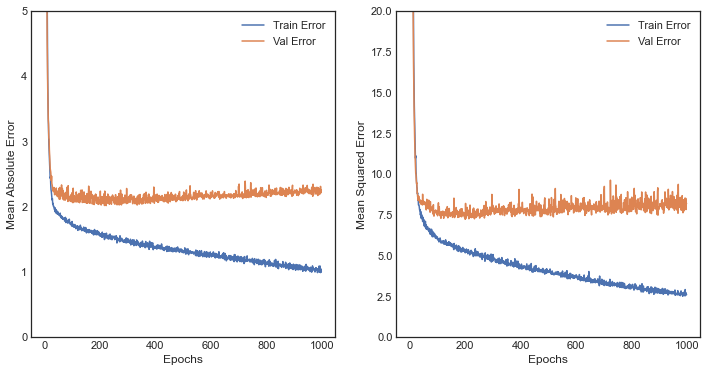

In [24]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize = (12, 6))
    
    plt.subplot(1, 2, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.plot(hist['epoch'], hist['mae'], label = 'Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([0, 5])
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.plot(hist['epoch'], hist['mse'], label = 'Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0, 20])
    plt.legend()
    
    plt.show()
    
plot_history(history)

### EarlyStopping을 이용한 규제화

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
model = build_model()

early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

history = model.fit(normed_train_data, train_labels, epochs = epochs,
                   validation_split = .2, callbacks = [early_stop])

Epoch 1/1000
8/8 [==============================] - 0s 20ms/step - loss: 563.5701 - mae: 22.4193 - mse: 563.5701 - val_loss: 554.1262 - val_mae: 22.1762 - val_mse: 554.1262
Epoch 2/1000
8/8 [==============================] - 0s 7ms/step - loss: 512.8988 - mae: 21.2962 - mse: 512.8988 - val_loss: 499.6048 - val_mae: 20.9372 - val_mse: 499.6048
Epoch 3/1000
8/8 [==============================] - 0s 9ms/step - loss: 461.3784 - mae: 20.0671 - mse: 461.3784 - val_loss: 440.5309 - val_mae: 19.4969 - val_mse: 440.5309
Epoch 4/1000
8/8 [==============================] - 0s 8ms/step - loss: 405.3268 - mae: 18.6573 - mse: 405.3268 - val_loss: 378.1368 - val_mae: 17.8561 - val_mse: 378.1368
Epoch 5/1000
8/8 [==============================] - 0s 8ms/step - loss: 346.3773 - mae: 17.0514 - mse: 346.3773 - val_loss: 312.7775 - val_mae: 15.9714 - val_mse: 312.7775
Epoch 6/1000
8/8 [==============================] - 0s 8ms/step - loss: 284.3597 - mae: 15.2222 - mse: 284.3597 - val_loss: 246.6902 - val_

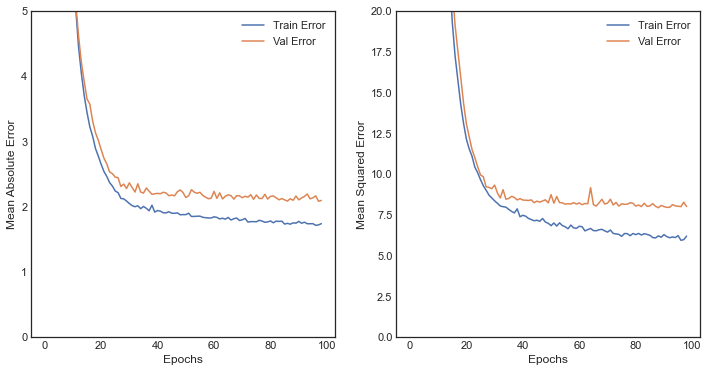

In [27]:
plot_history(history)

### 모델 평가

In [29]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose = 2)

print(mae)

3/3 - 0s - loss: 5.9283 - mae: 1.9082 - mse: 5.9283
1.9081851243972778


### 학습된 모델을 통한 예측

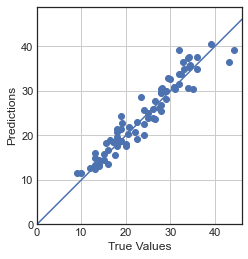

In [31]:
test_pred = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.grid()
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100]);

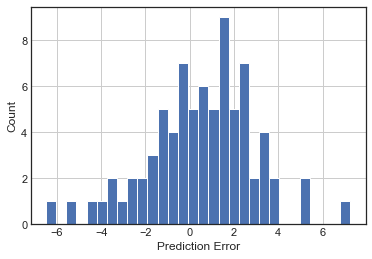

In [32]:
error = test_pred - test_labels
plt.hist(error, bins = 30)
plt.xlabel('Prediction Error')
plt.grid()
plt.ylabel('Count');